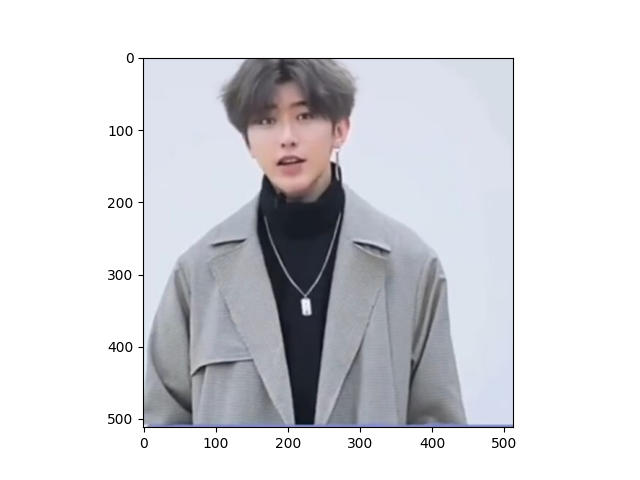

set positive point at x=218, y=257
set positive point at x=230, y=393
set negative point at x=309, y=310
set negative point at x=324, y=408


In [2]:
# from google.colab import output
# output.enable_custom_widget_manager()
%matplotlib ipympl

import matplotlib.pyplot as plt
from ipywidgets import interact

from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import torch
from PIL import Image
import torchvision.transforms as transforms

# Load image
image = plt.imread('assets/ikun.jpg')
image = cv2.resize(image, (512, 512)) # for saving memory if use SD-pipeline

# Create figure and axis
fig, ax = plt.subplots()

# Display image on axis
ax.imshow(image)

# Define function to get mouse coordinates
def onclick(event):
    # Get x and y coordinates of mouse click
    x, y = event.xdata, event.ydata
    if event.button == 1:
        # Store clicked coordinates in positive coords
        pos_coords.append((int(x), int(y)))
        ax.plot(int(x), int(y), 'go')
        print(f"set positive point at x={int(x)}, y={int(y)}")
    elif event.button == 3:
        # Store clicked coordinates in negative coords
        neg_coords.append((int(x), int(y)))
        ax.plot(int(x), int(y), 'ro')
        print(f"set negative point at x={int(x)}, y={int(y)}")

# Connect function to mouse click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Store clicked coordinates
pos_coords = []
neg_coords = []

# Display interactive plot
plt.show()

In [3]:
# Disconnect function from mouse click event
fig.canvas.mpl_disconnect(cid)

In [4]:
deviceID = 2
device = torch.device(f'cuda:{deviceID}' if torch.cuda.is_available() else 'cpu')

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  


In [5]:
from segment_anything import build_sam, SamPredictor 
sam_checkpoint = './sam_vit_h_4b8939.pth'
predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device=device))

In [6]:
predictor.set_image(image)
pos_points = np.array(pos_coords)
neg_points = np.array(neg_coords)
pos_labels = np.ones(len(pos_points))
neg_labels = np.zeros(len(neg_points))

In [7]:
masks, scores, logits = predictor.predict(
    point_coords=pos_points,
    point_labels=pos_labels,
    multimask_output=True,
)

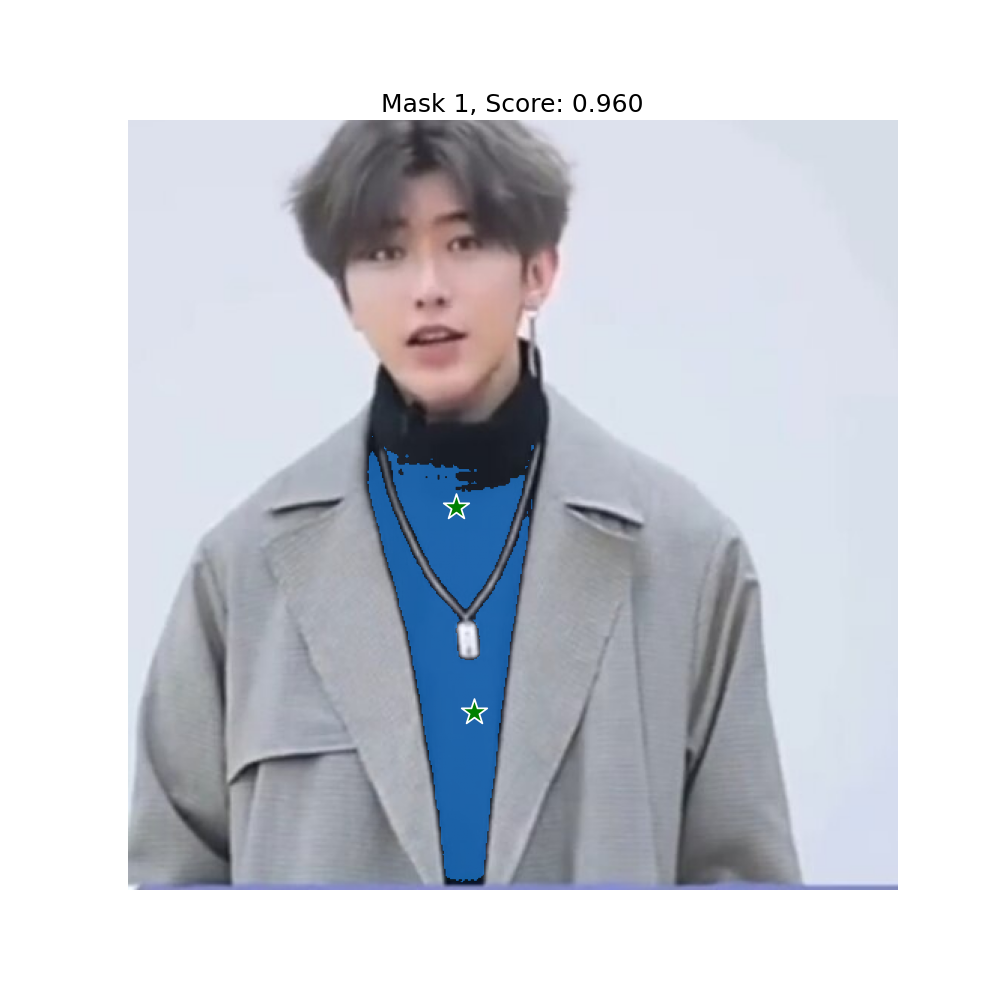

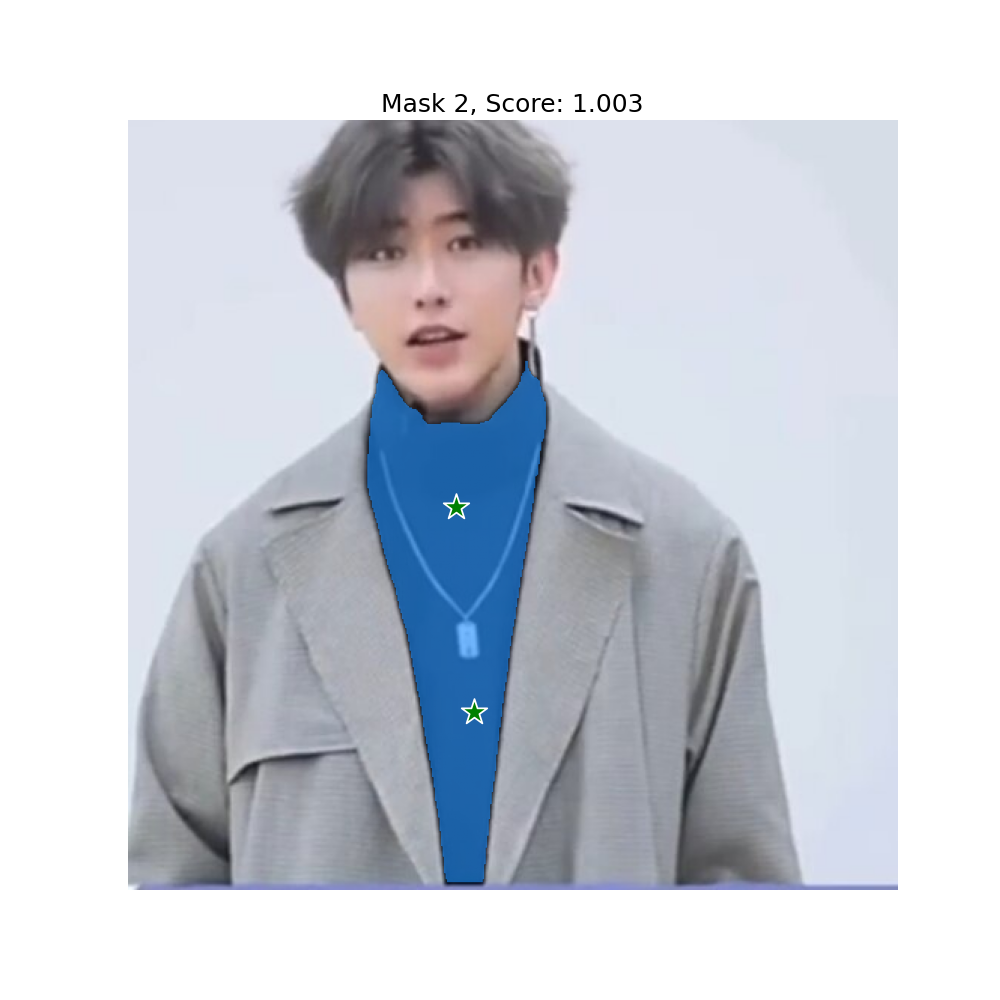

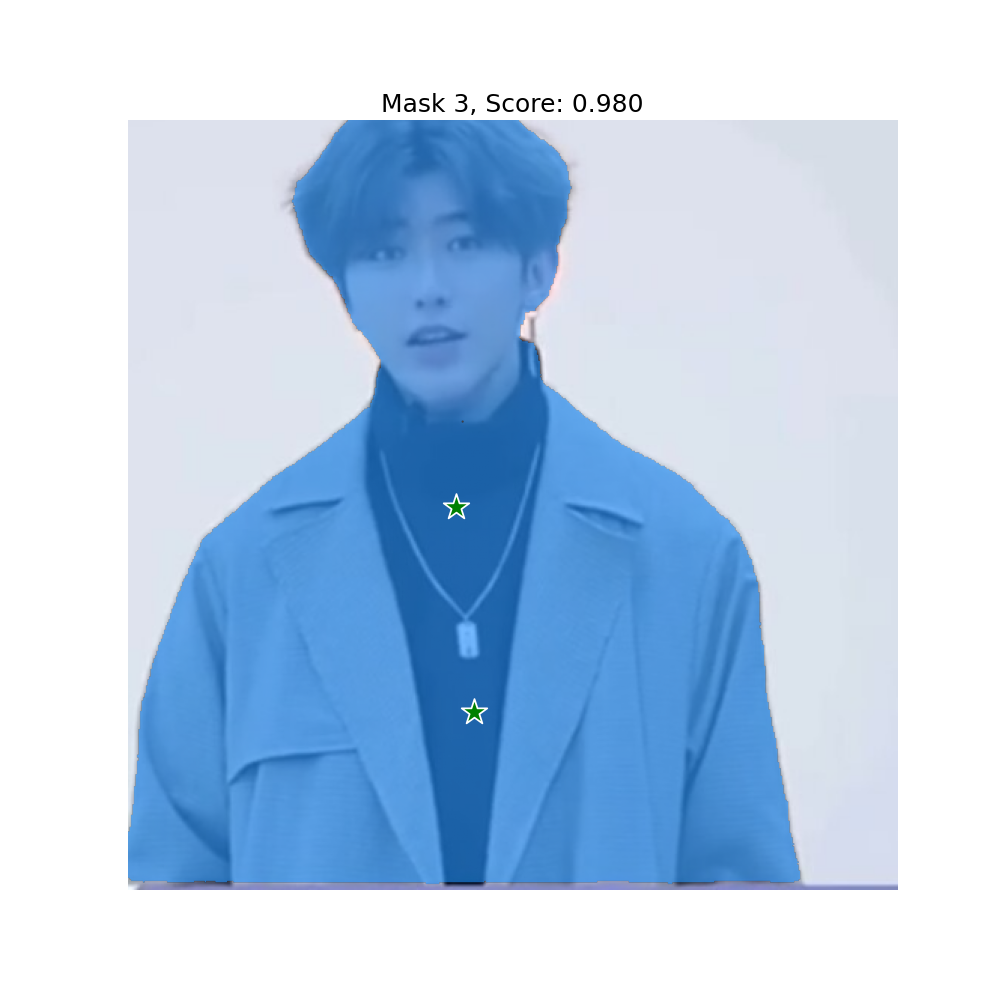

In [8]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(pos_points, pos_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

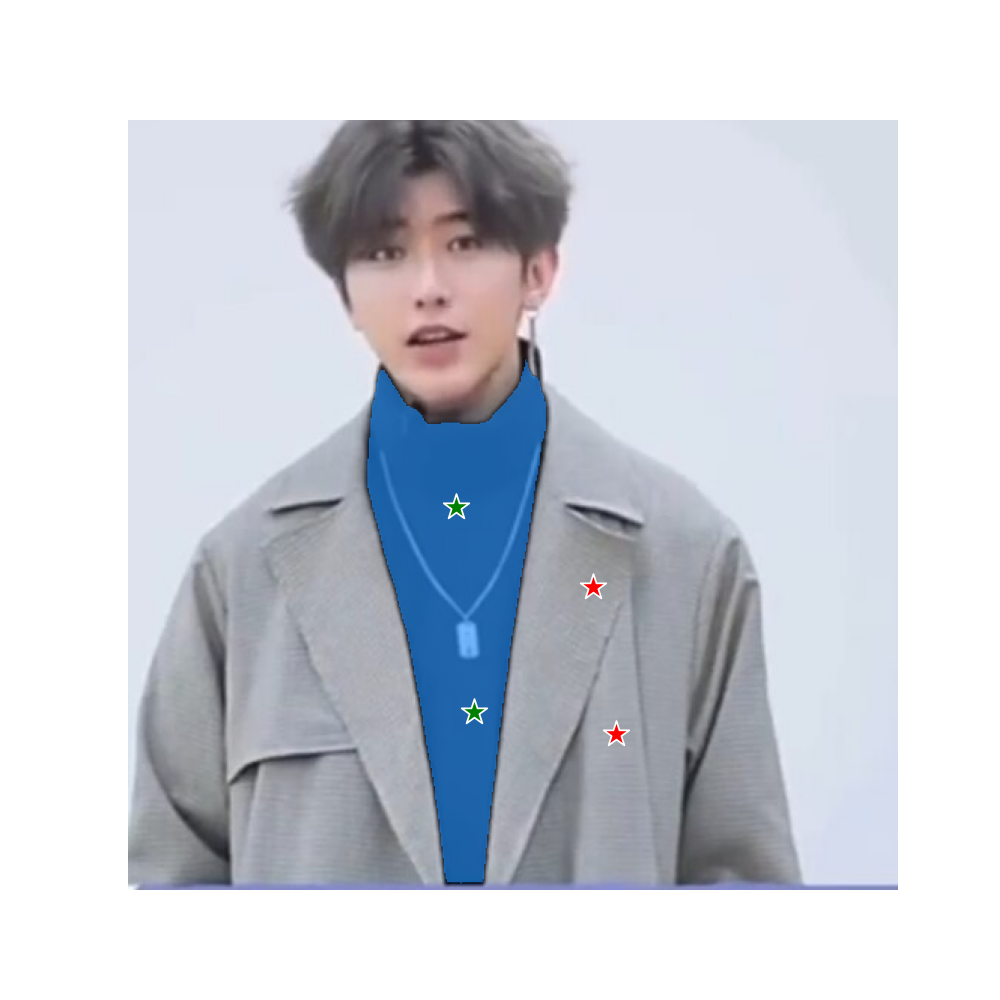

In [9]:
input_point = np.concatenate((pos_points, neg_points), axis=0)
input_label = np.concatenate((pos_labels, neg_labels), axis=0)
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [10]:
mask_pil = Image.fromarray(masks[0])
image_pil = Image.fromarray(image)

In [11]:
# diffusers

from diffusers import StableDiffusionInpaintPipeline

from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

# pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
pipe = pipe.to(device)
pipe.safety_checker = lambda images, clip_input: (images, False) # disable safety checker(not recommended)

2023-04-10 04:08:08.878894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 04:08:09.851229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

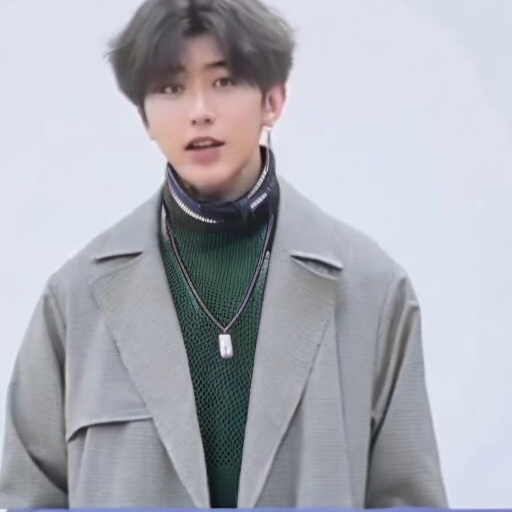

In [17]:
inpaint_prompt = 'high resolution, a man wearing a fashion green inner T-shirt, hightly detail'
guidance_scale = 7.5
num_inference_steps = 50
inpainted_image = pipe(prompt=inpaint_prompt, image=image_pil, mask_image=mask_pil, 
                       num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
inpainted_image